/home/croccodapps/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(2.1916, grad_fn=<DivBackward0>)
RECONSTRUCTION: 3229.8728 CLUSTERING: -423.88763 out of -438.3144
RECONSTRUCTION: 2655.8523 CLUSTERING: -572.34106 out of -438.3144
RECONSTRUCTION: 857.4453 CLUSTERING: -443.5531 out of -438.3144
RECONSTRUCTION: 473.7505 CLUSTERING: -435.36945 out of -438.3144
RECONSTRUCTION: 177.42984 CLUSTERING: -458.63535 out of -438.3144
RECONSTRUCTION: 116.712234 CLUSTERING: -484.0328 out of -438.3144
RECONSTRUCTION: 98.52729 CLUSTERING: -506.58472 out of -438.3144
RECONSTRUCTION: 91.513405 CLUSTERING: -555.51086 out of -438.3144
RECONSTRUCTION: 61.56766 CLUSTERING: -565.65326 out of -438.3144
RECONSTRUCTION: 32.028942 CLUSTERING: -567.2041 out of -438.3144
RECONSTRUCTION: 24.45234 CLUSTERING: -566.472 out of -438.3144
RECONSTRUCTION: 20.990192 CLUSTERING: -566.5138 out of -438.3144
RECONSTRUCTION: 19.595572 CLUSTERING: -569.21625 out of -438.3144
RECONSTRUCTION: 18.606812 CLUSTERING: -571.51196 out of -438.3144
RECONSTRUCTION: 17.518476 CLUSTERING: -573.1391

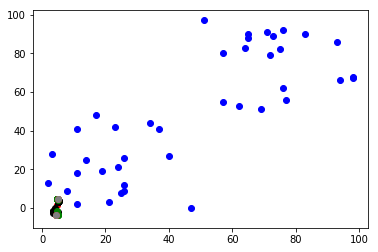

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
 
import copy
import random
 
transformed_dim = 5
 
 
# TODO try making an image out of the data points make the network a convolutional one
# will have to try n dimensional convolution
# also try n dimensional convolution by performing 2D convolution on every possible couple of dimensions
# put together all these results as probabilities and 'distances'
 
 
class Projector(nn.Module):
 
    def __init__(self):
        super(Projector, self).__init__()
        self.l0 = nn.Linear(2, 8)
        self.l0.weight.data.copy_(torch.randn(8, 2) * 1)
 
        self.l1 = nn.Linear(8, 8)
        self.l1.weight.data.copy_(torch.randn(8, 8) * 1)
 
        self.l2 = nn.Linear(8, transformed_dim)
        self.l2.weight.data.copy_(torch.randn(transformed_dim, 8) * 5)
 
    def forward(self, x):
        return self.l2(F.sigmoid(self.l1(F.sigmoid(self.l0(x)))))
 
 
K = 2           # number of clusters
n_points = 20
 
data = torch.from_numpy(np.concatenate((np.random.randint(0, 50, (n_points, 2)), np.random.randint(50, 100, (n_points, 2))), axis=0)).float()
 
 
def plot_transformation_field(data, transformed):
    """ has to be 2D data """
    for i in range(data.shape[0]):
        plt.arrow(data[i][0], data[i][1], transformed[i][0]-data[i][0], transformed[i][1]-data[i][1])
 
 
def cluster_loss(transformed, means):
    loss = 0
    for m in means:
        # print(m)
        for x in transformed:
            loss -= loss_radius * torch.exp(-((x-m)**2)/loss_radius)
 
    return loss.sum()
 
 
def initialize_clusters(k, R):
    """ k equally space clusters in an nD space
    range: [(min, max) for i in nD] """
 
    return torch.Tensor([[(D[0]-D[1])*(i+1)/(k+1) + D[1] for D in R] for i in range(k)]).float()
 
 
def plot_clusters(clusters):
    """ only works in 2D """
    for c in clusters:
        plt.scatter(c[0], c[1], color='r')
 
 
"""transformed = nn.Parameter(copy.deepcopy(data))
 
optimizer = optim.Adam([transformed], lr=1e-3)
loss_radius = 40
 
# clusters = Variable(torch.randint(0, 100, (2, transformed_dim))).float()
clusters = Variable(torch.cat((torch.Tensor([25, 25]).unsqueeze(0).float(), torch.Tensor([75, 75]).unsqueeze(0).float()), dim=0))"""
 
 
projector = Projector()
decoder = nn.Sequential(nn.Linear(transformed_dim, 5), nn.ReLU(), nn.Linear(5, 5), nn.ReLU(), nn.Linear(5, 2))
 
transformed = projector(Variable(data))
 
 
max_values, _ = torch.max(transformed, 0)
min_values, _ = torch.min(transformed, 0)
 
R = torch.cat((max_values.unsqueeze(0), min_values.unsqueeze(0)), dim=0).data.numpy().T
 
clusters = nn.Parameter(initialize_clusters(2, R))
 
p_optimizer = optim.Adam(list(projector.parameters())+[clusters], lr=1e-4)
d_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)
 
plot_clusters(copy.deepcopy(clusters.detach()))
 
# alternatively use a fixed radius and add clusters in case the data doesn't fit well
loss_radius = torch.norm(clusters[0] - clusters[1], 2) / 2
print(loss_radius)
 
plt.scatter(transformed[:, 0].data.numpy(), transformed[:, 1].data.numpy(), c=(0, 0, 0))
original_transformed = copy.deepcopy(transformed.data.numpy())
 
min_loss = -(loss_radius*n_points*transformed_dim*clusters.shape[0])
 
for i in range(int(3e4)):
 
    reconstruction_loss = F.mse_loss(decoder(transformed), data)
    clustering_loss = cluster_loss(transformed, clusters)
 
    loss = clustering_loss + reconstruction_loss
 
    loss.backward(retain_graph=True)            # TODO find out why retain_graph has to be True
 
    if True:
        p_optimizer.step()
        p_optimizer.zero_grad()
    else:
        print('threshold reached', clustering_loss, min_loss)
        break
 
    d_optimizer.step()
    d_optimizer.zero_grad()
 
    transformed = projector(Variable(data))
 
    if i % 2000 == 0:
        print('RECONSTRUCTION:', reconstruction_loss.data.numpy(),
              'CLUSTERING:', clustering_loss.data.numpy(), 'out of', min_loss.data.numpy())
 
 
plt.scatter(transformed[:, 0].data.numpy(), transformed[:, 1].data.numpy(), color='g')
plot_clusters(clusters.detach())
plt.scatter(clusters.detach()[:, 0], clusters.detach()[:, 1], c=(0.5, 0.5, 0.5))
# plot_transformation_field(original_transformed, transformed.data.numpy())
# plot_transformation_field(data.data.numpy(), original_transformed)
plt.show()